In [1]:
import matplotlib.pyplot as plt
import matplotlib
import geopandas
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import cartopy.crs as ccrs
import numpy as np

def scale_bar(ax, length=None, location=(0.5, 0.05), linewidth=3):
    """
    ax is the axes to draw the scalebar on.
    length is the length of the scalebar in km.
    location is center of the scalebar in axis coordinates.
    (ie. 0.5 is the middle of the plot)
    linewidth is the thickness of the scalebar.
    """
    #Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    #Make tmc horizontally centred on the middle of the map,
    #vertically at scale bar location
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    #Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    #Calculate a scale bar length if none has been given
    #(Theres probably a more pythonic way of rounding the number but this works)
    if not length: 
        length = (x1 - x0) / 5000 #in km
        ndim = int(np.floor(np.log10(length))) #number of digits in number
        length = round(length, -ndim) #round to 1sf
        #Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']: return int(x)        
            else: return scale_number(x - 10 ** ndim)
        length = scale_number(length) 

    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx - length * 500, sbx + length * 500]
    #Plot the scalebar
    ax.plot(bar_xs, [sby, sby], transform=tmc, color='k', linewidth=linewidth)
    #Plot the scalebar label
    ax.text(sbx, sby, str(length) + ' km', transform=tmc,
            horizontalalignment='center', verticalalignment='bottom')

In [4]:
municipios = geopandas.read_file('municipios/Municipios_IBGE.shp')

In [5]:
municipios.head()

,MSLINK,MAPID,AREA_1,PERIMETRO_,NOME,SEDE,LATITUDESE,LONGITUDES,AREA_TOT_G,Cod_ibge,Label_N,geometry
0,4985,99,118.280,61.626,HERVEIRAS,1,-29.407,-52.653,118.280,4309571,Herveiras,"POLYGON ((-52.77319 -29.44486, -52.77602 -29.4..."
1,4986,99,228.849,81.715,HORIZONTINA,1,-27.626,-54.308,228.849,4309605,Horizontina,"POLYGON ((-54.39910 -27.57012, -54.38675 -27.5..."
2,4987,99,822.943,184.883,HULHA NEGRA,1,-31.404,-53.869,822.943,4309654,Hulha Negra,"POLYGON ((-53.98933 -31.55208, -53.99221 -31.5..."
3,4988,99,135.246,70.392,HUMAITA,1,-27.563,-53.974,135.246,4309704,Humaitá,"POLYGON ((-54.07227 -27.57674, -54.06089 -27.5..."
4,4989,99,193.109,70.655,IBARAMA,1,-29.419,-53.135,193.109,4309753,Ibarama,"POLYGON ((-53.26582 -29.44975, -53.26701 -29.4..."


In [6]:
producao = pd.read_excel("Arrecadacao_2020.xlsx", index_col=0)
producao = producao.fillna(0)

In [7]:
producao.head(20)

,ÁGATA,ÁGUA MINERAL,AMETISTA,AREIA,AREIA FLUVIAL,AREIA QUARTZOSA,ARENITO,ARGILA,BASALTO,BASALTO P/ BRITA,...,CASCALHO,CAULIM,DIABÁSIO,GIPSITA,GNAISSE,GRANITO,RIÓLITO,SAIBRO,SIENITO,TALCO
Arrecadação de CFEM 2020 (completo),,,,,,,,,,,,,,,,,,,,,
Água Santa,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,36388.62,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0
Agudo,0.00,0.00,0.00,0.00,0.0,0.0,0.0,324.72,0.00,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0
Alecrim,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,2314.63,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0
Alegrete,0.00,0.00,0.00,962.49,0.0,0.0,0.0,0.00,16060.27,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.60,0.0,0.0
Alegria,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,3282.14,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0
Alvorada,0.00,1277.23,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0
Amaral Ferrador,0.00,0.00,0.00,1238.12,0.0,0.0,0.0,0.00,0.00,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0
Ametista do Sul,1399.22,0.00,549619.79,0.00,0.0,0.0,0.0,0.00,0.00,0.0,...,0.00,0.0,0.0,90.0,0.0,0.00,0.0,0.00,0.0,0.0
Anta Gorda,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,14483.85,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0


In [8]:
mapa_arrecadacao = {
'AREIA FLUVIAL':'AREIA',
'AREIA QUARTZOSA':'AREIA',
'AREIA FLUVIA':'AREIA',
'BASALTO P/ BRITA':'BASALTO',
'BASALTO P/ REVESTIMENTO':'BASALTO',
'CALCÁRIO CALCÍTICO':'CALCÁRIO',
'CALCÁRIO DOLOMÍTICO':'CALCÁRIO',
'CALCÁRIO INDUSTRIAL':'CALCÁRIO',
'CARVÃO MINERAL':'CARVÃO',
}

In [9]:
for i in producao.columns:
    for j in mapa_arrecadacao:
        if i == j:
            producao[mapa_arrecadacao[i]] = producao[j] + producao[mapa_arrecadacao[i]]
            producao.drop(j, inplace=True, axis=1)

In [10]:
producao.head(20)

,ÁGATA,ÁGUA MINERAL,AMETISTA,AREIA,ARENITO,ARGILA,BASALTO,CALCÁRIO,CALCEDÔNIA,CALCITA,...,CASCALHO,CAULIM,DIABÁSIO,GIPSITA,GNAISSE,GRANITO,RIÓLITO,SAIBRO,SIENITO,TALCO
Arrecadação de CFEM 2020 (completo),,,,,,,,,,,,,,,,,,,,,
Água Santa,0.00,0.00,0.00,0.00,0.0,0.00,36388.62,0.00,0.00,0.00,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0
Agudo,0.00,0.00,0.00,0.00,0.0,324.72,0.00,0.00,0.00,0.00,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0
Alecrim,0.00,0.00,0.00,0.00,0.0,0.00,2314.63,0.00,0.00,0.00,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0
Alegrete,0.00,0.00,0.00,962.49,0.0,0.00,16060.27,0.00,0.00,0.00,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.60,0.0,0.0
Alegria,0.00,0.00,0.00,0.00,0.0,0.00,3282.14,0.00,0.00,0.00,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0
Alvorada,0.00,1277.23,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0
Amaral Ferrador,0.00,0.00,0.00,1238.12,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0
Ametista do Sul,1399.22,0.00,549619.79,0.00,0.0,0.00,0.00,0.00,0.00,269.26,...,0.00,0.0,0.0,90.0,0.0,0.00,0.0,0.00,0.0,0.0
Anta Gorda,0.00,0.00,0.00,0.00,0.0,0.00,14483.85,0.00,0.00,0.00,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0


In [11]:
producao['CALCÁRIO'][producao['CALCÁRIO'] > 0]

Arrecadação de CFEM 2020 (completo)
Arroio Grande          849.85
Caçapava do Sul     367104.45
Candiota            332592.90
Dom Feliciano       120864.55
Pantano Grande      450650.42
Pedro Osório         20989.70
São Gabriel         171630.11
Vila Nova do Sul    105092.63
Name: CALCÁRIO, dtype: float64

In [12]:
for idx, row in producao.iterrows():
    if row["CARVÃO"] != 0:
        print(idx, row["CARVÃO"]/1000)

Arroio dos Ratos 3408.64606
Butiá 568.78664
Cachoeira do Sul 619.14586
Candiota 3446.90613
Charqueadas 8.224440000000001
Minas do Leão 251.52915


In [13]:
n_municipios = geopandas.GeoDataFrame(crs='EPSG:4326')
for index, row in producao.iterrows():
    for index1, row1 in municipios.iterrows():
        if row1['Label_N'] == index:
            n_municipios = n_municipios.append(row1)
n_municipios.set_crs(epsg=4326, inplace=True)

,AREA_1,AREA_TOT_G,Cod_ibge,LATITUDESE,LONGITUDES,Label_N,MAPID,MSLINK,NOME,PERIMETRO_,SEDE,geometry
313,291.792,291.792,4300059.0,-28.177,-52.034,Água Santa,99.0,4807.0,AGUA SANTA,83.884,1.0,"POLYGON ((-52.14370 -28.24375, -52.13661 -28.2..."
314,536.117,536.117,4300109.0,-29.645,-53.240,Agudo,99.0,4808.0,AGUDO,163.562,1.0,"POLYGON ((-53.36258 -29.63863, -53.34897 -29.6..."
316,314.745,314.745,4300307.0,-27.655,-54.764,Alecrim,99.0,4810.0,ALECRIM,111.330,1.0,"POLYGON ((-54.90270 -27.69939, -54.90698 -27.6..."
317,7803.967,7803.967,4300406.0,-29.783,-55.792,Alegrete,99.0,4811.0,ALEGRETE,566.825,1.0,"POLYGON ((-56.66093 -29.42373, -56.64881 -29.4..."
318,172.686,172.686,4300455.0,-27.827,-54.057,Alegria,99.0,4812.0,ALEGRIA,98.193,1.0,"POLYGON ((-54.16147 -27.79790, -54.14928 -27.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...
274,113.887,113.887,4322855.0,-29.068,-51.859,Vespasiano Correa,99.0,5259.0,VESPASIANO CORREA,51.784,1.0,"POLYGON ((-51.92647 -29.07603, -51.92680 -29.0..."
276,1494.263,1494.263,4323002.0,-30.081,-51.023,Viamão,99.0,5261.0,VIAMAO,219.714,1.0,"POLYGON ((-51.08636 -30.04655, -51.06188 -30.0..."
279,107.815,107.815,4323309.0,-28.863,-51.533,Vila Flores,99.0,5264.0,VILA FLORES,56.161,1.0,"POLYGON ((-51.66763 -28.83527, -51.57682 -28.8..."
281,181.440,181.440,4323408.0,-28.535,-52.154,Vila Maria,99.0,5266.0,VILA MARIA,93.125,1.0,"POLYGON ((-52.23587 -28.54882, -52.23504 -28.5..."


In [14]:
n_municipios.head()

,AREA_1,AREA_TOT_G,Cod_ibge,LATITUDESE,LONGITUDES,Label_N,MAPID,MSLINK,NOME,PERIMETRO_,SEDE,geometry
313,291.792,291.792,4300059.0,-28.177,-52.034,Água Santa,99.0,4807.0,AGUA SANTA,83.884,1.0,"POLYGON ((-52.14370 -28.24375, -52.13661 -28.2..."
314,536.117,536.117,4300109.0,-29.645,-53.240,Agudo,99.0,4808.0,AGUDO,163.562,1.0,"POLYGON ((-53.36258 -29.63863, -53.34897 -29.6..."
316,314.745,314.745,4300307.0,-27.655,-54.764,Alecrim,99.0,4810.0,ALECRIM,111.330,1.0,"POLYGON ((-54.90270 -27.69939, -54.90698 -27.6..."
317,7803.967,7803.967,4300406.0,-29.783,-55.792,Alegrete,99.0,4811.0,ALEGRETE,566.825,1.0,"POLYGON ((-56.66093 -29.42373, -56.64881 -29.4..."
318,172.686,172.686,4300455.0,-27.827,-54.057,Alegria,99.0,4812.0,ALEGRIA,98.193,1.0,"POLYGON ((-54.16147 -27.79790, -54.14928 -27.7..."


In [15]:
grupos = {'Materiais para construção civil':['AREIA', 'AREIA DE FUNDIÇÃO', 'AREIA QUARTZOSA', 'AREIA COMUM', 'AREIA FLUVIAL', 'ARENITO', 'ARGILA', 'ARGILA REFRATÁRIA', 'ARGILITO', 'BASALTO', 'BASALTO P/ BRITA', 'BENTONITA', 'CALCÁRIO', 'CALCÁRIO CALCÍTICO', 'CASCALHO', 'DIABÁSIO', 'DIABÁSIO P/ BRITA', 'GABRO', 'GNAISSE', 'GRANITO', 'QUARTZITO', 'RIÓLITO', 'SAIBRO', 'CALCITA', 'GIPSITA'],
#'Insumos agrícolas': ['CALCÁRIO', 'CALCÁRIO DOLOMÍTICO', 'CALCÁRIO CALCÍTICO', 'CALCÁRIO CONCHÍFERO', 'CONCHAS CALCÁRIAS', 'PEDRA CALCÁRIA', 'CAULIM', 'DOLOMITO', 'FOSFATO', 'TALCO'],
'Insumos agrícolas': ['CALCÁRIO'],
'Recursos energéticos': ['ANTRACITO', 'ARENITO BETUMINOSO', 'CARVÃO MINERAL', 'CARVÃO', 'FOLHELHO BETUMINOSO', 'FOLHELHO PIROBETUMINOSO', 'LINHITO', 'ROCHA BETUMINOSA', 'SAPROPELITO', 'TURFA'],
'Minerais metálicos': ['CASSITERITA', 'CHUMBO', 'COBRE', 'FERRO', 'ILMENITA', 'LIMONITA', 'MINÉRIO DE CHUMBO', 'MINÉRIO DE COBRE', 'MINÉRIO DE OURO', 'MINÉRIO DE TITÂNIO', 'MINÉRIO DE ZINCO', 'MOLIBDÊNIO', 'OURO', 'PRATA', 'TANTALITA', 'TITÂNIO'],
'Indústria cerâmica': ['ARGILA', 'CALCÁRIO', 'ARGILA REFRATÁRIA', 'ARGILA VERMELHA', 'ARGILA CAULÍNICA', 'ARGILA P/CER. VERMELH', 'ARGILITO', 'BENTONITA', 'CAULIM', 'FILITO'],
'Rochas ornamentais': ['ANORTOSITO', 'ARENITO', 'BASALTO', 'BASALTO P/ REVESTIMENTO', 'DIABÁSIO', 'GRANITO', 'GRANITO ORNAMENTAL', 'MÁMORE', 'QUARTZITO', 'RIÓLITO', 'SIENITO'],  
'Pedras preciosas':['ÁGATA', 'ÁGUA MARINHA', 'AMETISTA', 'CALCEDÔNIA', 'CITRINO', 'GEMA', 'OPALA', 'QUARTZO'],
'Águas minerais': ['ÁGUA MINERAL ALC. BIC', 'ÁGUA MINERAL', 'ÁGUA POTÁVEL DE MESA']
         }

In [16]:
lista_municipio = ['Caxias do Sul', 'Santa Maria', 'Porto Alegre', 'Pelotas']
def plot_municipios(municipios, lista_municipio, ax, c='black', delta=0.05):
    x = []
    y = []
    for index, row in municipios.iterrows():
        for m in lista_municipio:
            if row['NOME'] == m.upper():
                y.append(row['LATITUDESE'])
                x.append(row['LONGITUDES'])
    ax.scatter(x=x, y=y, marker='x', c=c)
    for i, txt in enumerate(lista_municipio[::-1]):
        ax.annotate(txt, (x[i]+delta, y[i]+delta), c=c)

In [17]:
x_pts = []
y_pts = []

geometrias = n_municipios['geometry'].to_crs("EPSG:4326")
for g in geometrias:
    cent = g.centroid
    x_pts.append(cent.x)
    y_pts.append(cent.y)

In [18]:
minerais = producao.columns[1:]

In [19]:
minerais

Index(['ÁGUA MINERAL', 'AMETISTA', 'AREIA', 'ARENITO', 'ARGILA', 'BASALTO',
       'CALCÁRIO', 'CALCEDÔNIA', 'CALCITA', 'CARVÃO', 'CASCALHO', 'CAULIM',
       'DIABÁSIO', 'GIPSITA', 'GNAISSE', 'GRANITO', 'RIÓLITO', 'SAIBRO',
       'SIENITO', 'TALCO'],
      dtype='object')

In [45]:
norm = 0.0015

In [46]:
def which_bin(v, bin_edges, n_bins=5, norm=1):
    size = None
    if v == 0:
        size = 0
    else:
        for i in range(n_bins):
            limits = bin_edges[i:i+2]
            if v >= limits[0] and v <= limits[1]:
                size=np.mean(limits)
    return size * norm

In [47]:
import numpy as np
def create_legend(producao, n_bins=5, norm=1):
    valores = producao.values.flatten()
    hist, bin_edges = np.histogram(valores, bins=5)
    bin_edges
    legend = []
    sizes = []
    for i in range(n_bins):
        limits = bin_edges[i:i+2]
        s = np.mean(limits)
        l = 'de {} a {}'.format(int(limits[0]/1000), int(limits[1]/1000))
        legend.append(l)
        sizes.append(s)
    abs_leg = ['{}'.format(int(round(i/1000))) for i in sizes]
    return abs_leg, np.array(sizes) * norm

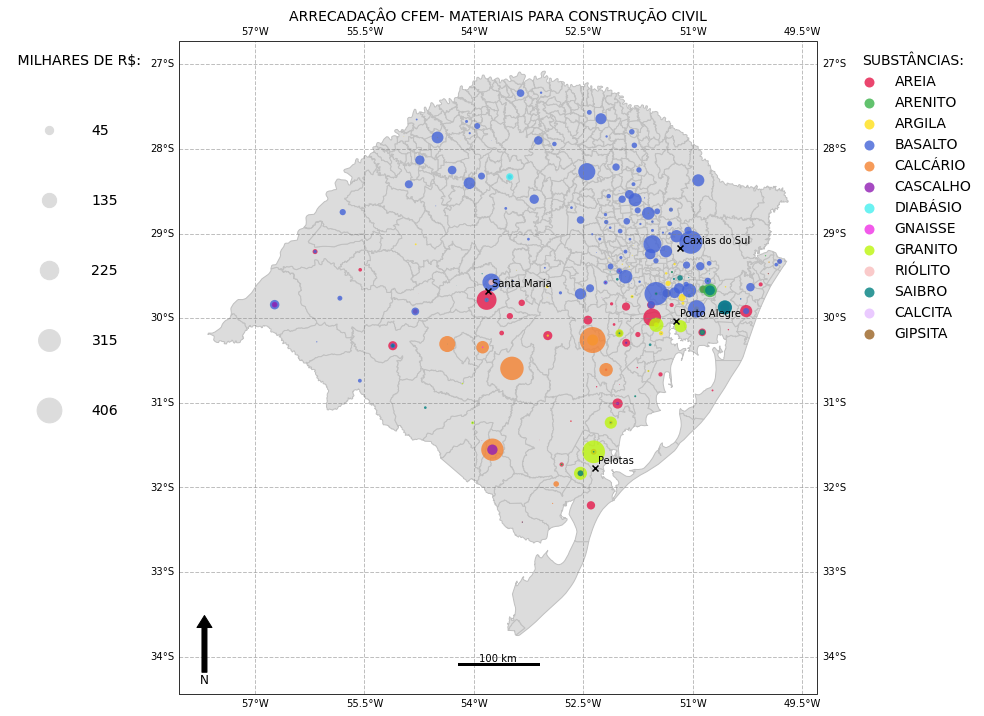

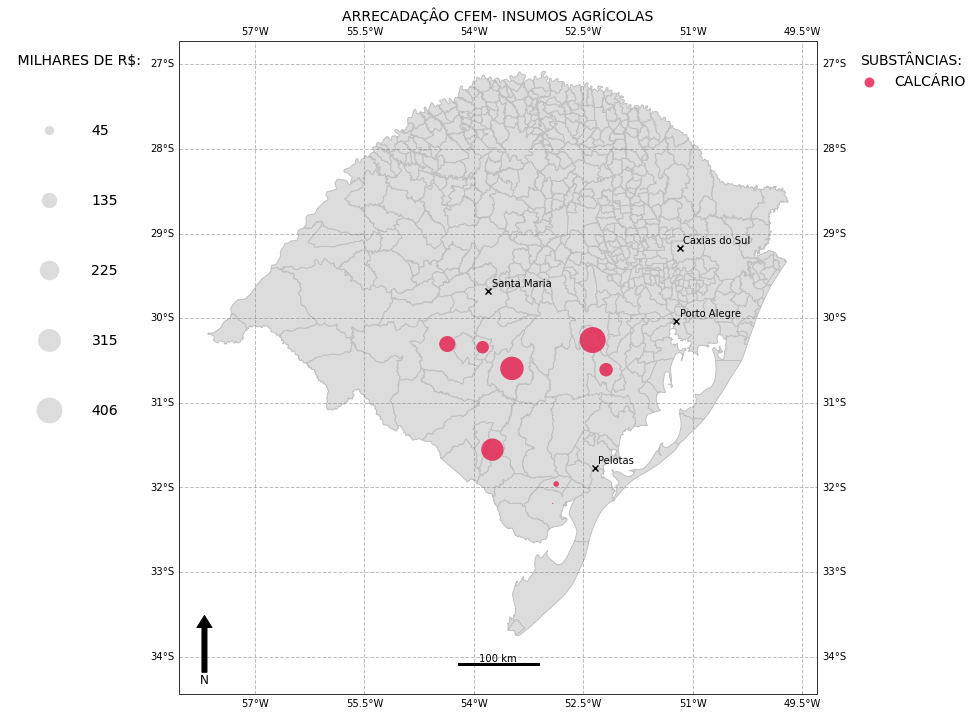

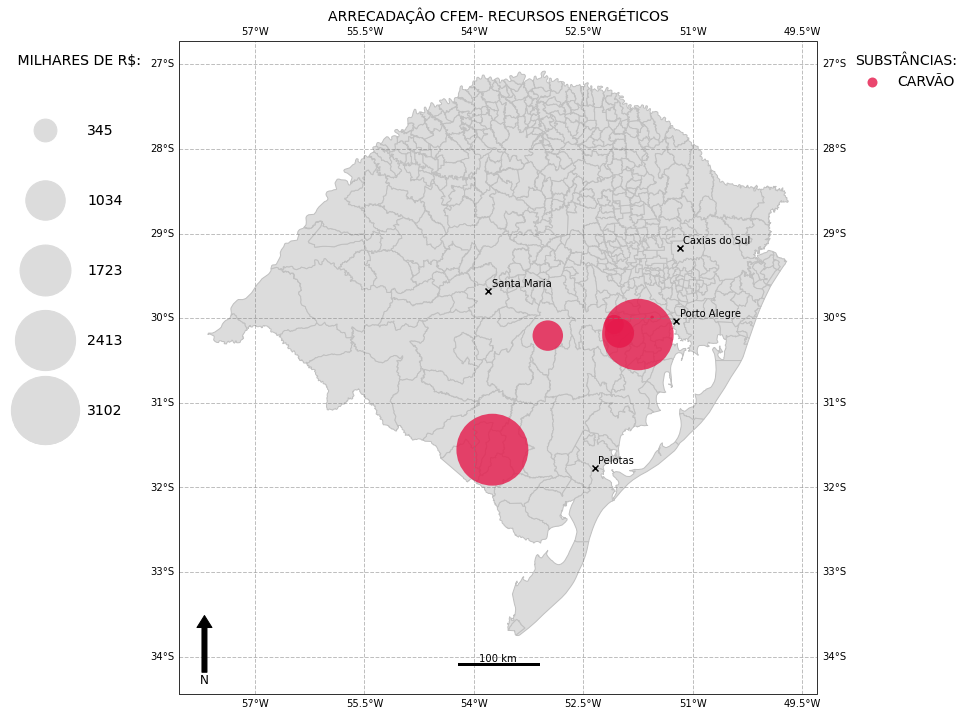

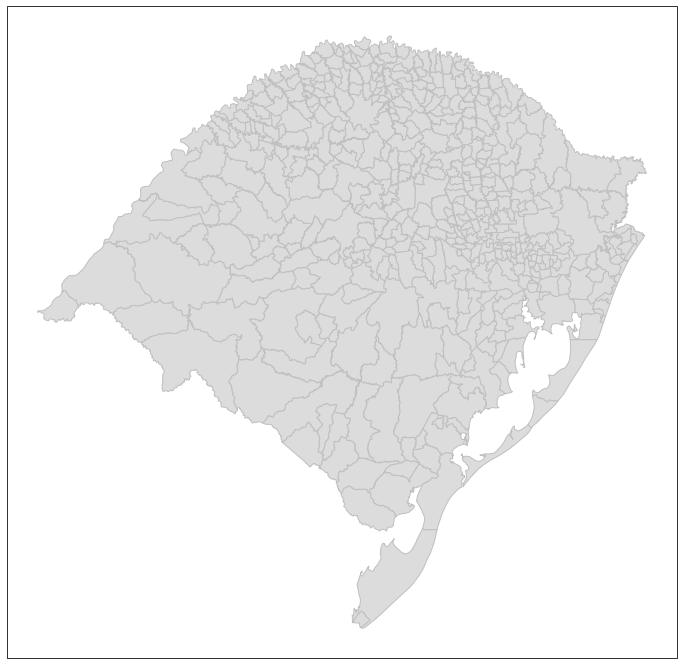

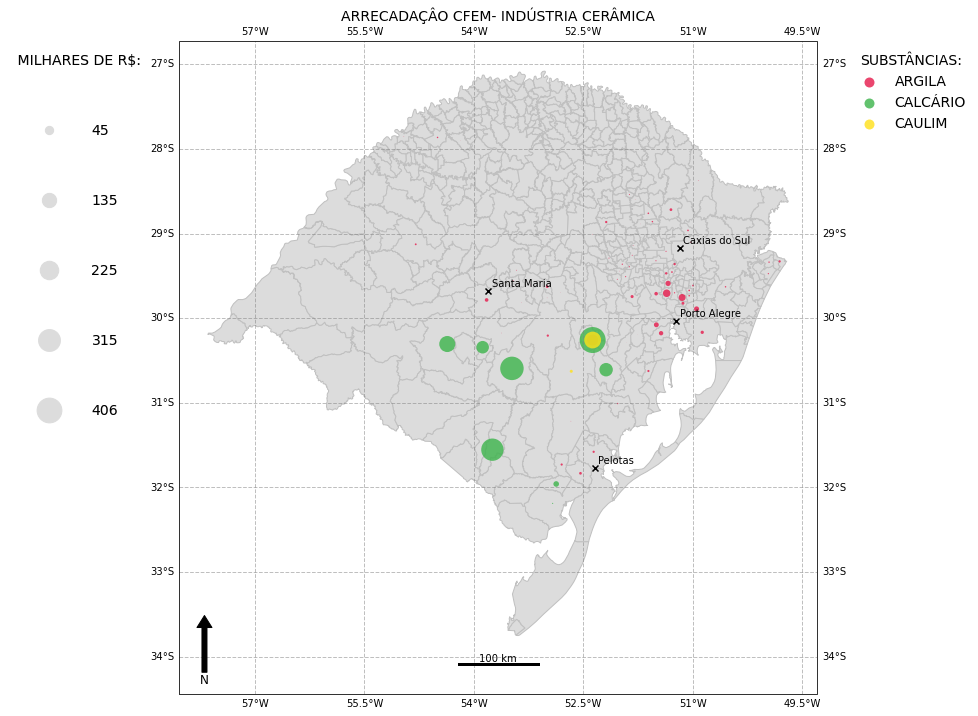

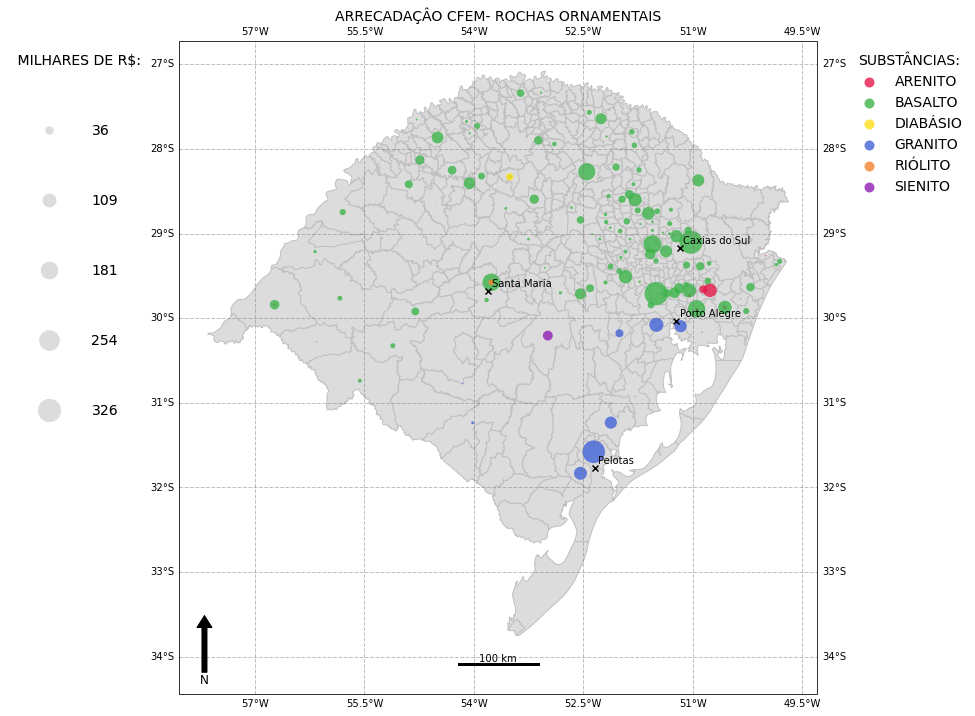

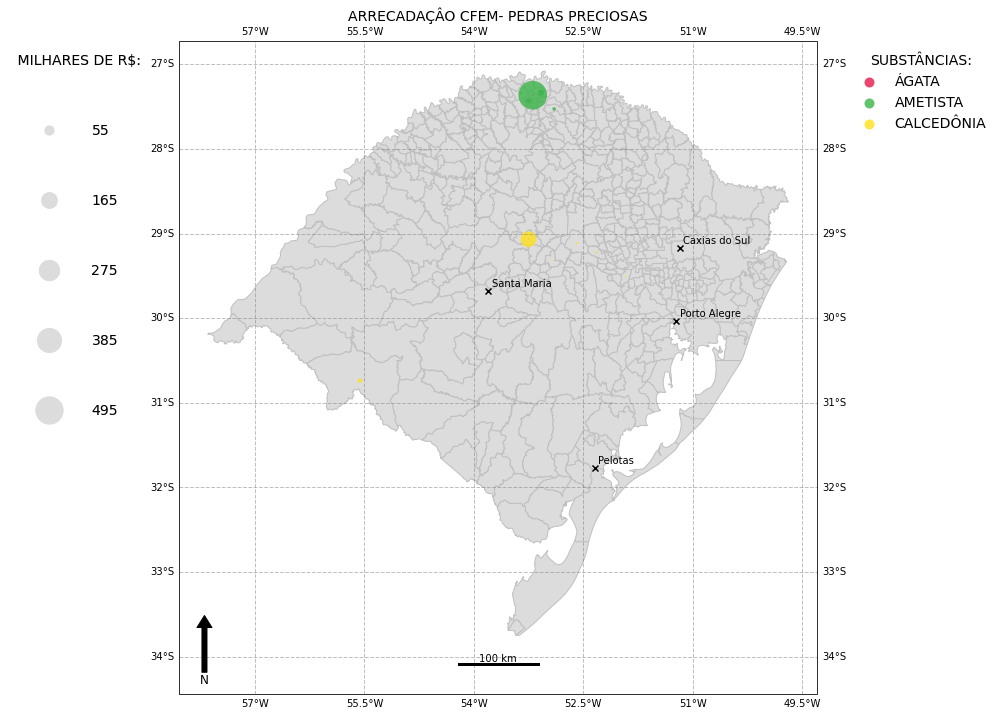

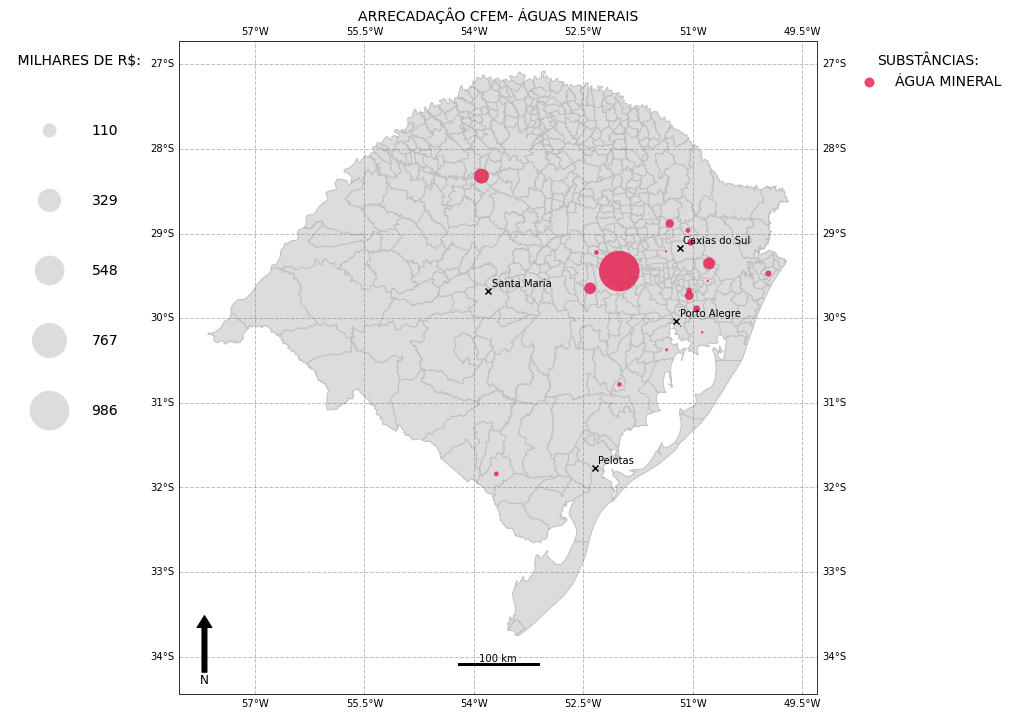

In [48]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

for grupo in grupos:
    
    fig, ax = plt.subplots(figsize=(12,12), subplot_kw={'projection': ccrs.PlateCarree()})
    municipios.plot(ax=ax, color='gainsboro', edgecolor='silver')
    
    colunas = grupos[grupo]
    n_c = []
    for i in colunas:
        if i in list(producao.columns):
            n_c.append(i)
    
    if len(n_c) == 0:
        continue 
    
    filtrado = producao[n_c]
    l, ss = create_legend(filtrado, n_bins=5, norm=norm)
    
    #colors
    #colormap = plt.cm.Set1
    #colors = [colormap(i) for i in np.linspace(0, 1, len(n_c))]
    #colors = sns.color_palette("Set2", len(n_c))
    colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
    ax.set_prop_cycle('color', colors)
    
    for mineral in filtrado.columns:    
        #s = [which_bin(v=i, bin_edges=bin_edges, n_bins=5, norm=norm) for i in producao[mineral]]
        s = producao[mineral] * norm
        scatter = plt.scatter(x_pts, y_pts, alpha=0.8, s=s, label=mineral, linewidths=0)
        
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
    #gl.xlabels_top = False

    x, y, arrow_length = 0.04, 0.12, 0.1
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
    arrowprops=dict(facecolor='black', width=5, headwidth=15),
    ha='center', va='center', fontsize=12,
    xycoords=ax.transAxes)

    scale_bar(ax, 100, location=(0.5,0.01))
    
    test = plt.scatter(x=np.ones(len(ss))*-54, y=np.ones(len(ss))*-30, s=ss, alpha=0)
    handles, labels = test.legend_elements(prop="sizes", alpha=0.6)
    labels = l
    kw = dict(prop="sizes")
    
    lgd1 = ax.legend(bbox_to_anchor=(1.04, 1), edgecolor = 'white', fontsize='14', title='SUBSTÂNCIAS:', title_fontsize='14', loc='upper left')
    for handle in lgd1.legendHandles:
        handle.set_sizes([100.0])
    lgd2 = ax.legend(handles, labels, labelspacing=4, handletextpad=2 , bbox_to_anchor=(-0.04, 1), edgecolor = 'white', fontsize='14', title=' MILHARES DE R$:', title_fontsize='14', loc='upper right')
    nl = []
    for i, handle in enumerate(lgd2.legendHandles):
        handle._legmarker.set_alpha(1)
        handle._legmarker.set_color('gainsboro')

    plt.gca().add_artist(lgd1)
    plt.gca().add_artist(lgd2)
    
    plot_municipios(municipios, lista_municipio, ax, c='black', delta=0.05)

    ax.set_title('ARRECADAÇÂO CFEM- {}'.format(grupo.upper()), loc='center', fontsize='14')
    nome = grupo.upper()
    plt.savefig('imagens/arrecadacao/'+nome+".png", bbox_inches='tight', facecolor='white', dpi = 300, bbox_extra_artists=(lgd1,lgd2, ax))

In [ ]:
alturas = np.array([np.sum(producao[a]) for a in producao.columns])
nomes = np.array(list(producao.columns))
inds = alturas.argsort()
nomes = nomes[inds]
alturas = alturas[inds]
x = np.arange(len(nomes))
plt.bar(x, alturas)
plt.xticks(x, nomes, rotation='vertical')
plt.ylabel('Arrecadação em R$')
plt.title('Arrecadação CFEM por substância')
plt.grid(alpha=0.3)
plt.savefig("imagens/arrecadacao/barras.png", bbox_inches='tight', facecolor='white', dpi = 300)